We will be analyzing restaurant data from the different restaurants we specified in Progress Report #1.

In [3]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/aimeeoh/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/aimeeoh/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/aimeeoh/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/aimeeoh/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/aimeeoh/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading pa

True

In [5]:
data = pd.read_csv('data/mei-lai-wah-bakery/csv/detailed-reviews-of-mei-lai-wah-bakery.csv')

df = data[['place_name', 'rating', 'review_text', 'published_at_date']]
df

,place_name,rating,review_text,published_at_date
0,Mei Lai Wah,5,Best Roast Pork Buns in town! Order dimsun her...,2024-03-28 17:44:46.795169
1,Mei Lai Wah,1,There s a big pc meat bone in the roast pork b...,2024-03-28 17:44:46.804498
2,Mei Lai Wah,5,"Very nice! The buns are soft and full of meat,...",2024-03-28 16:44:46.808813
3,Mei Lai Wah,4,"Great spot to grab cheap, delicious and fulfil...",2024-03-28 16:44:46.813084
4,Mei Lai Wah,4,Very packed and good pineapple buns. The tea w...,2024-03-28 16:44:46.816795
...,...,...,...,...
2135,Mei Lai Wah,5,NaN,2012-03-28 18:50:24.284148
2136,Mei Lai Wah,4,"CHEAP spot to get steamed buns, dim sum and co...",2012-03-28 18:50:24.286351
2137,Mei Lai Wah,4,Ive passed by this place all the time when I w...,2012-03-28 18:50:24.289082
2138,Mei Lai Wah,5,"Originally known as Mei Lai Wah, is now Mei Li...",2012-03-28 18:50:24.291497


Extracting Year from 'published_at_date' column

In [6]:
df['published_at_date'] = pd.to_datetime(df['published_at_date']).dt.year
df

/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_12893/2592446673.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['published_at_date'] = pd.to_datetime(df['published_at_date']).dt.year


,place_name,rating,review_text,published_at_date
0,Mei Lai Wah,5,Best Roast Pork Buns in town! Order dimsun her...,2024
1,Mei Lai Wah,1,There s a big pc meat bone in the roast pork b...,2024
2,Mei Lai Wah,5,"Very nice! The buns are soft and full of meat,...",2024
3,Mei Lai Wah,4,"Great spot to grab cheap, delicious and fulfil...",2024
4,Mei Lai Wah,4,Very packed and good pineapple buns. The tea w...,2024
...,...,...,...,...
2135,Mei Lai Wah,5,NaN,2012
2136,Mei Lai Wah,4,"CHEAP spot to get steamed buns, dim sum and co...",2012
2137,Mei Lai Wah,4,Ive passed by this place all the time when I w...,2012
2138,Mei Lai Wah,5,"Originally known as Mei Lai Wah, is now Mei Li...",2012


Charts for ratings

<AxesSubplot: >

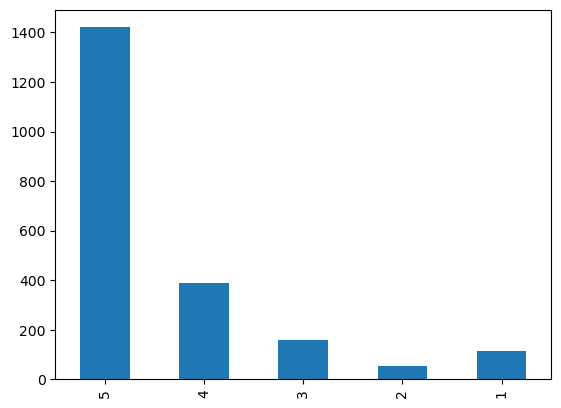

In [7]:
df['rating'].value_counts()[[5, 4, 3, 2, 1]].plot(kind='bar')

<AxesSubplot: title={'center': 'Restaurant Ratings'}, ylabel='rating'>

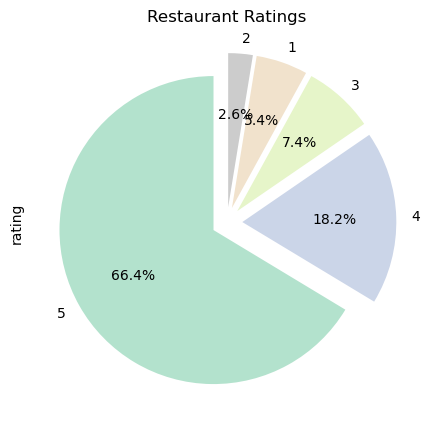

In [8]:
kwargs = dict(
    startangle = 90,
    colormap   = 'Pastel2',
    fontsize   = 10,
    explode    = (0.1,0.1,0.1,0.1,0.1),
    figsize    = (60,5),
    autopct    = '%1.1f%%',
    title      = 'Restaurant Ratings'
)

df['rating'].value_counts().plot.pie(**kwargs)

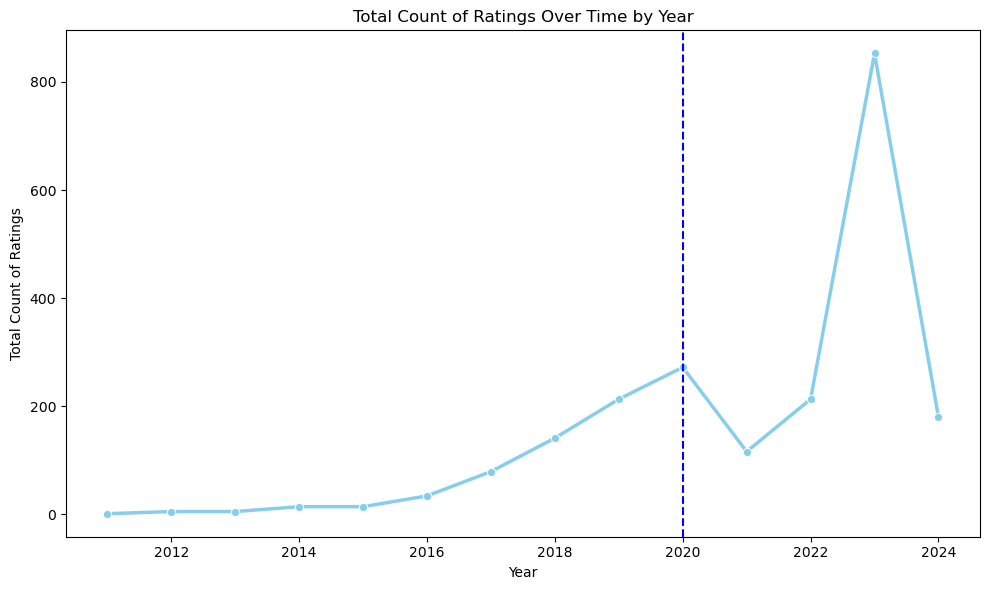

In [9]:
rating_counts = df.groupby(['published_at_date', 'rating']).size().unstack(fill_value=0)

total_ratings_per_year = rating_counts.sum(axis=1)

plt.figure(figsize=(10, 6))
sns.lineplot(data=total_ratings_per_year, marker='o', color='skyblue', linewidth=2.5)
plt.axvline(x=2020, color='blue', linestyle='--', label='Year 2020')


plt.title('Total Count of Ratings Over Time by Year')
plt.xlabel('Year')
plt.ylabel('Total Count of Ratings')
plt.tight_layout()
plt.show()

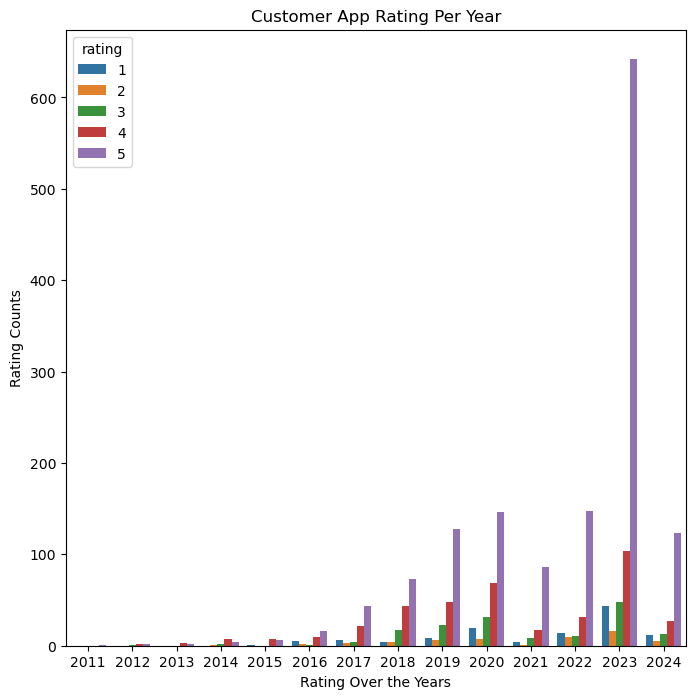

In [10]:
plt.figure(figsize=(8, 8))
sns.countplot(x = 'published_at_date', hue ='rating', data = df)
plt.title('Customer App Rating Per Year')
plt.xlabel("Rating Over the Years")
plt.ylabel('Rating Counts')
plt.show()

In [11]:
df['review_text'] = df['review_text'].astype("string")

df[['review_text']]

/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_12893/2693296585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_text'] = df['review_text'].astype("string")


,review_text
0,Best Roast Pork Buns in town! Order dimsun her...
1,There s a big pc meat bone in the roast pork b...
2,"Very nice! The buns are soft and full of meat,..."
3,"Great spot to grab cheap, delicious and fulfil..."
4,Very packed and good pineapple buns. The tea w...
...,...
2135,<NA>
2136,"CHEAP spot to get steamed buns, dim sum and co..."
2137,Ive passed by this place all the time when I w...
2138,"Originally known as Mei Lai Wah, is now Mei Li..."


In [12]:
import re
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
stop_words_file = 'Stopwords.txt'

stop_words = []

with open(stop_words_file, "r") as f:
    for line in f:
        stop_words.extend(line.split()) 
        
stop_words = stop_words  

def preprocess(raw_text):
    
    #regular expression keeping only letters 
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split into words -> convert string into list ( 'hello world' -> ['hello', 'world'])
    words = letters_only_text.lower().split()

    cleaned_words = []
    lemmatizer = PorterStemmer() #plug in here any other stemmer or lemmatiser you want to try out
    
    # remove stopwords
    for word in words:
        if word not in stop_words:
            cleaned_words.append(word)
    
    # stemm or lemmatise words
    stemmed_words = []
    for word in cleaned_words:
        word = lemmatizer.stem(word)   #dont forget to change stem to lemmatize if you are using a lemmatizer
        stemmed_words.append(word)
    
    # converting list back to string
    return " ".join(stemmed_words)

In [13]:
test_sentence = "Service was excellent, food was delicious, and vibe was great ! We got the korean style boneless fried chicken (sweet chili sauce was fire), veg buckwheat pancake, and spicy chicken. Our server was so kind and attentive & we had a great experience; the sweet treat cookie at end was so cute :)"

preprocess(test_sentence)

'servic excel food delici vibe great korean style boneless fri chicken sweet chili sauc fire veg buckwheat pancak spici chicken server kind attent great experi sweet treat cooki end cute'

In [14]:
prep = []

for text in df['review_text']:
    if pd.isna(text):
        prep.append('')
    else:
        prep.append(preprocess(text))

df['prep'] = prep

df.head()

/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_12893/1628437642.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prep'] = prep


,place_name,rating,review_text,published_at_date,prep
0,Mei Lai Wah,5,Best Roast Pork Buns in town! Order dimsun her...,2024,roast pork bun town order dimsun
1,Mei Lai Wah,1,There s a big pc meat bone in the roast pork b...,2024,big pc meat bone roast pork bun order crash te...
2,Mei Lai Wah,5,"Very nice! The buns are soft and full of meat,...",2024,nice bun soft full meat meat flavor tender ser...
3,Mei Lai Wah,4,"Great spot to grab cheap, delicious and fulfil...",2024,great spot grab cheap delici fulfil chines foo...
4,Mei Lai Wah,4,Very packed and good pineapple buns. The tea w...,2024,pack good pineappl bun tea nice price reason


In [15]:
from collections import Counter
Counter(" ".join(df["prep"]).split()).most_common(50)

[('bun', 1673),
 ('pork', 1209),
 ('good', 388),
 ('roast', 354),
 ('pineappl', 341),
 ('order', 265),
 ('place', 260),
 ('food', 248),
 ('bake', 247),
 ('delici', 238),
 ('line', 221),
 ('great', 201),
 ('fill', 171),
 ('chinatown', 162),
 ('servic', 157),
 ('steam', 148),
 ('sweet', 145),
 ('price', 129),
 ('time', 125),
 ('cash', 120),
 ('wait', 111),
 ('eat', 107),
 ('meat', 106),
 ('fat', 103),
 ('amaz', 101),
 ('worth', 100),
 ('cheap', 98),
 ('love', 98),
 ('insid', 96),
 ('tast', 95),
 ('long', 93),
 ('back', 91),
 ('recommend', 89),
 ('fresh', 87),
 ('bread', 81),
 ('mei', 80),
 ('wah', 79),
 ('nyc', 78),
 ('bao', 76),
 ('chines', 75),
 ('fast', 74),
 ('rice', 71),
 ('tasti', 71),
 ('roll', 69),
 ('pay', 68),
 ('flavor', 67),
 ('super', 63),
 ('bbq', 62),
 ('peopl', 62),
 ('visit', 62)]

In [16]:
def create_sentiment(rating):
    
    if rating==1 or rating==2:
        return -1 # negative sentiment
    elif rating==4 or rating==5:
        return 1 # positive sentiment
    else:
        return 0 # neutral sentiment

df['sentiment'] = df['rating'].apply(create_sentiment)
df

/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_12893/1400198503.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['rating'].apply(create_sentiment)


,place_name,rating,review_text,published_at_date,prep,sentiment
0,Mei Lai Wah,5,Best Roast Pork Buns in town! Order dimsun her...,2024,roast pork bun town order dimsun,1
1,Mei Lai Wah,1,There s a big pc meat bone in the roast pork b...,2024,big pc meat bone roast pork bun order crash te...,-1
2,Mei Lai Wah,5,"Very nice! The buns are soft and full of meat,...",2024,nice bun soft full meat meat flavor tender ser...,1
3,Mei Lai Wah,4,"Great spot to grab cheap, delicious and fulfil...",2024,great spot grab cheap delici fulfil chines foo...,1
4,Mei Lai Wah,4,Very packed and good pineapple buns. The tea w...,2024,pack good pineappl bun tea nice price reason,1
...,...,...,...,...,...,...
2135,Mei Lai Wah,5,<NA>,2012,,1
2136,Mei Lai Wah,4,"CHEAP spot to get steamed buns, dim sum and co...",2012,cheap spot steam bun dim sum conge love standa...,1
2137,Mei Lai Wah,4,Ive passed by this place all the time when I w...,2012,ive pass place time younger knew miss friend i...,1
2138,Mei Lai Wah,5,"Originally known as Mei Lai Wah, is now Mei Li...",2012,origin mei lai wah mei li wah rare find antiqu...,1


<AxesSubplot: xlabel='sentiment', ylabel='count'>

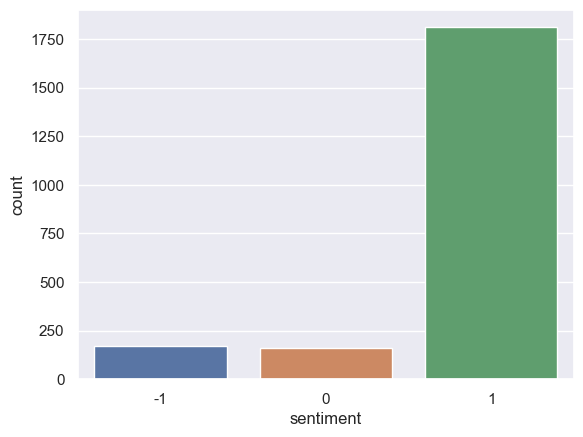

In [17]:
sns.set_theme()

# Create a visualization
sns.countplot(
    data=df,
    x="sentiment"
)

In [18]:
# initialize NLTK sentiment analyzer

analyzer = SentimentIntensityAnalyzer()


# create get_sentiment function

def get_sentiment(text):

    scores = analyzer.polarity_scores(text)

    sentiment = 1 if scores['pos'] > 0 else 0

    return scores['compound']




# apply get_sentiment function

df['review_sentiment'] = df['prep'].apply(get_sentiment)

df['review_sentiment']

/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_12893/3818571148.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_sentiment'] = df['prep'].apply(get_sentiment)


0       0.0000
1      -0.4767
2       0.6249
3       0.9607
4       0.6908
         ...  
2135    0.0000
2136    0.2732
2137    0.6808
2138    0.9153
2139    0.0000
Name: review_sentiment, Length: 2140, dtype: float64

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None, 
                        lowercase=False,
                        preprocessor=None)

X = tfidf.fit_transform(df['prep'])

from sklearn.model_selection import train_test_split
y = df['sentiment'] # target variable
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [20]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train,y_train) # fit the model
preds = lr.predict(X_test) # make predictions

In [21]:
from sklearn.metrics import accuracy_score
accuracy_score(preds,y_test)

0.8654205607476636

<AxesSubplot: xlabel='published_at_date', ylabel='review_sentiment'>

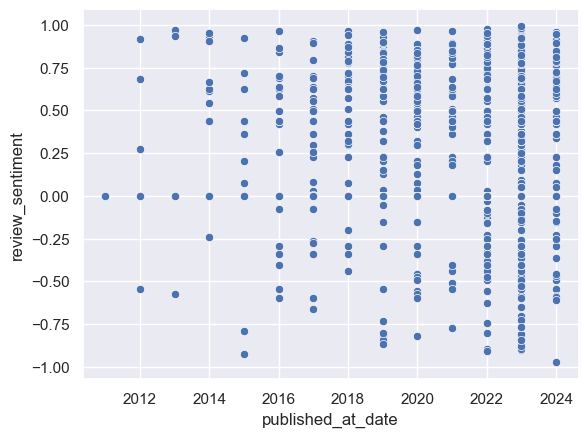

In [22]:
sns.scatterplot(data=df, x='published_at_date', y='review_sentiment')

<AxesSubplot: xlabel='published_at_date', ylabel='review_sentiment'>

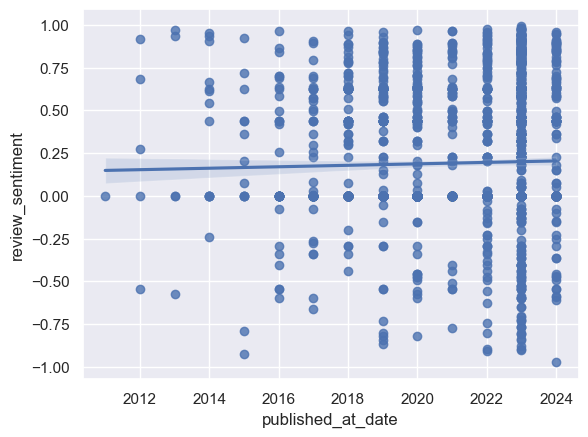

In [23]:
sns.regplot(x="published_at_date", y="review_sentiment", data=df)

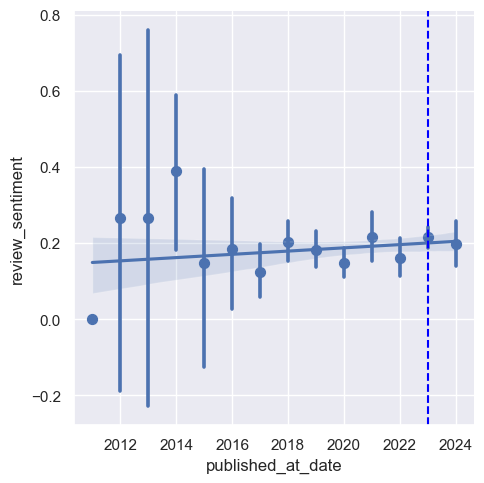

In [24]:
sns.lmplot(x="published_at_date", y="review_sentiment", data=df, x_estimator=np.mean)
plt.axvline(x=2023, color='blue', linestyle='--', label='Year 2023')

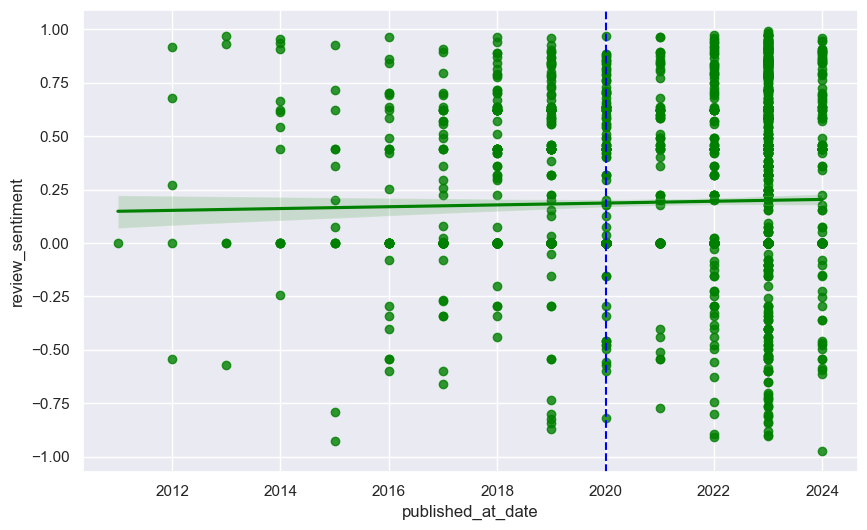

In [25]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='published_at_date', y='review_sentiment', marker='o', color='green')
plt.axvline(x=2020, color='blue', linestyle='--', label='Year 2020')

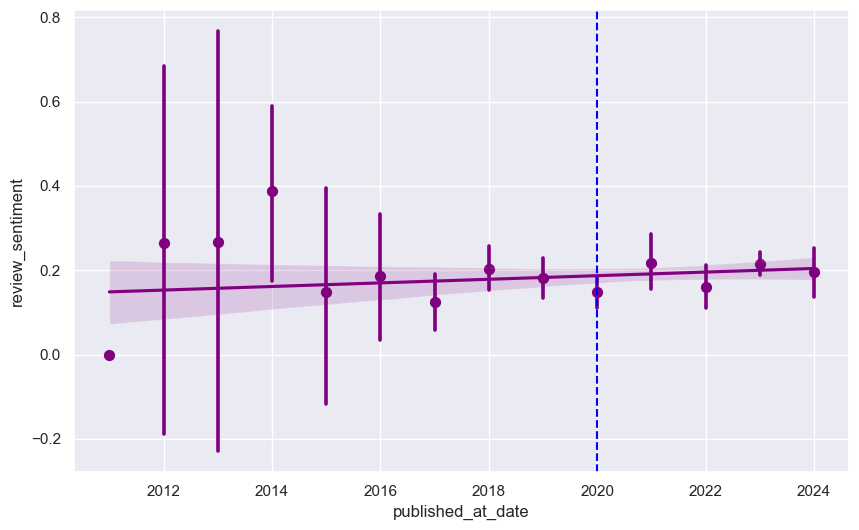

In [28]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='published_at_date', y='review_sentiment', marker='o', color='purple', x_estimator=np.mean)
plt.axvline(x=2020, color='blue', linestyle='--', label='Year 2020')

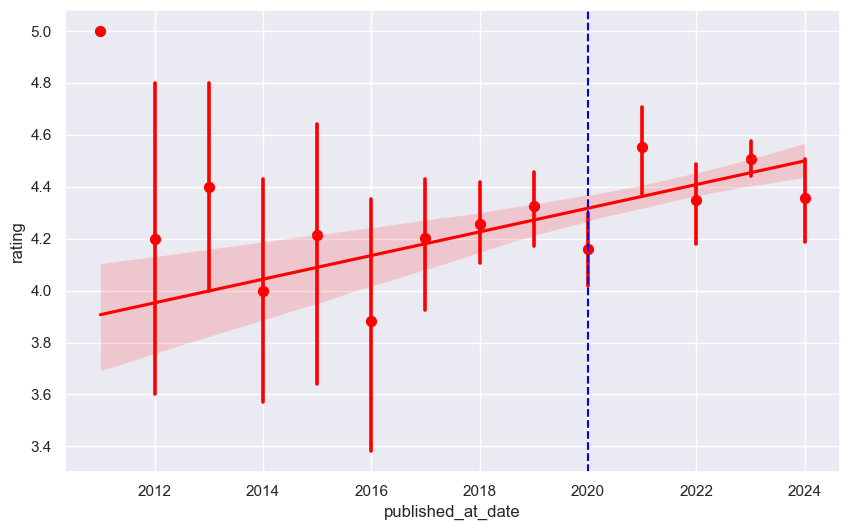

In [27]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='published_at_date', y='rating', marker='o', color='red', x_estimator=np.mean)
plt.axvline(x=2020, color='blue', linestyle='--', label='Year 2020')

In [26]:
# make altered data into csv file
df.to_csv('altdata/' + 'meilaiwah.csv', index=False)